# Python For Finance: Algorithmic Trading
#### Source: https://www.datacamp.com/community/tutorials/moving-averages-in-pandas

https://www.datacamp.com/community/tutorials/finance-python-trading#backtesting

In [77]:
# requirement
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
# Config
company_name = "AAPL" # company to be trade
timestamp_from = "2019-01-01" # period of time since
timestamp_to =  "2020-06-30" # period of time to
short_window = 3 # define short window
long_window = 10 # define long window

## Importing Financial Data Into Python

In [92]:
# get stock information of Tesla(TSLA)
company = yf.Ticker(company_name)
hist = company.history(period="max")
df2 = hist.loc[pd.Timestamp(timestamp_from):pd.Timestamp(timestamp_to)] # period defined in config

# get mutilpe stock information, period = since 2019-01-01 to current
# data = yf.download("AAPL MSFT IBM GOOG", start='2019-01-01', end = '2022-12-31')

# new df=sma, with column= Close stock value
sma = df2.iloc[:,3:4]

# checker
print('There are :', sma.shape[0], 'datapoints')

There are : 370 datapoints


## Trading Strategy
Simple trading strategy: simple moving average

https://www.datacamp.com/community/tutorials/finance-python-trading#A-Simple_Trading_Strategy



In [95]:
# Initialize the short and long windows in config

# 3, 10 days simple moving average (SMA), using close value
sma['sma_3'] = sma['Close'].rolling(window=short_window).mean()
sma['sma_10'] = sma['Close'].rolling(window=long_window).mean()
# sma.fillna(0, inplace=True) # fill NA as 0

# Create signals, compare short window and long window
sma['signal'] = 0.0

sma['signal'][short_window:] = np.where(sma['sma_3'][short_window:]> sma['sma_10'][short_window:], 1.0, 0.0)   
# if short > long window, upward = 1
# if short <= long window, downward = 0

# Generate trading orders
sma['positions'] = sma['signal'].diff()
# 1 to 0 = -1, sell-signal
# 0 to 1 = 1, buy signal

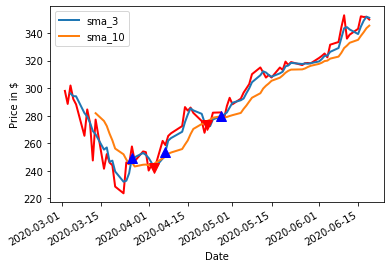

In [81]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
sma['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
sma[['sma_3', 'sma_10']].plot(ax=ax1, lw=2.)

# Plot the buy signals plot(x,y)
ax1.plot(sma.loc[sma.positions == 1.0].index, 
         sma.sma_3[sma.positions == 1.0],
         '^', markersize=10, color='b')
         
# Plot the sell signals
ax1.plot(sma.loc[sma.positions == -1.0].index, 
         sma.sma_3[sma.positions == -1.0],
         'v', markersize=10, color='r')
         
# Show the plot
plt.show()

# Backtester

https://www.datacamp.com/community/tutorials/finance-python-trading#Implementation-Of-A-Simple-Backtester

In [91]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions` from signals of SMA
positions = pd.DataFrame(index=sma.index).fillna(0.0)

# Buy a 100 shares
# when signal = 1 + short cross long (for the period greater than the shortest moving average window), buy a 100 shares.
positions['TSLA'] = 100*sma['signal']   
  
# Initialize the portfolio with value owned
# portfolio - generates orders and manages Profit & Loss (“PnL”)
portfolio = positions.multiply(sma['Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
# stores the value of the shares you have bought
portfolio['holdings'] = (positions.multiply(sma['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
# calc the capital that you still have left to spend
portfolio['cash'] = initial_capital - (pos_diff.multiply(sma['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
# stores the sum of your cash and the holdings (shares)
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the last lines of `portfolio`
portfolio.tail(1)


,TSLA,holdings,cash,total,returns
Date,,,,,
2020-06-19,34972.0,34972.0,78035.0,113007.0,-0.001775


## Visualiztion
### visualize the profolio value over the years, ie results of backtest

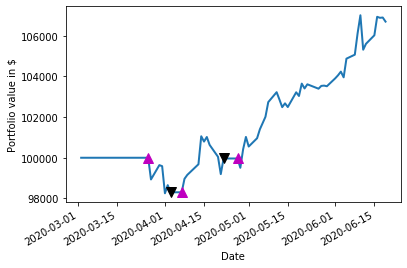

In [83]:
# Create a figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[sma.positions == 1.0].index, 
         portfolio.total[sma.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[sma.positions == -1.0].index, 
         portfolio.total[sma.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()